In [1]:
import time 
start = time.time()

import fastf1
import fastf1.plotting
import fastf1.api

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os  
from datetime import timedelta
import csv
import seaborn as sns
from fastf1.ergast import Ergast
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import fastf1
import fastf1.plotting
from datetime import timedelta
import os
import pandas as pd
import numpy as np
import sys

year = 2025
race_number = 14
race_session = 'R'
Lap_Number = 44
team = 'Ferrari'

session= fastf1.get_session(year, race_number, race_session)
session.load()

teams = fastf1.plotting.list_team_names(session)
team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
event_name = session.event.EventName

/home/kurios/Documents/f1_analysis/f1_analysis_env/lib/python3.10/site-packages/fastf1/api.py:32: UserWarning: `fastf1.api` will be considered private in future releases and potentially be removed or changed!
  warnings.warn("`fastf1.api` will be considered private in future releases and "
req         WARNING 	DEFAULT CACHE ENABLED! (31.06 GB) /home/kurios/.cache/fastf1
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data fo

In [122]:
def fixed_nat_all_laps(team, session):
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
    
    try:
        driver_1_laps = session.laps.pick_drivers(team_drivers[0]).pick_laps(range(0, (int(max(session.laps['LapNumber'])) + 1))).reset_index()
    except:
        driver_1_laps = pd.DataFrame()
    try:
        driver_2_laps = session.laps.pick_drivers(team_drivers[1]).pick_laps(range(0, (int(max(session.laps['LapNumber'])) + 1))).reset_index()
    except:
        driver_2_laps = pd.DataFrame()
    if not driver_1_laps.empty:
        laptime_counter_driver_1 = 0
        for lap in driver_1_laps['LapTime']:
            try:
                if 'NaT' in str(lap):
                    driver_1_laps.loc[laptime_counter_driver_1, 'LapTime'] = driver_1_laps.loc[laptime_counter_driver_1 +1, 'LapStartTime'] - driver_1_laps.loc[laptime_counter_driver_1, 'LapStartTime']
                laptime_counter_driver_1 +=1
            except KeyError:
                break

    if not driver_2_laps.empty:
        laptime_counter_driver_2 = 0
        for lap in driver_2_laps['LapTime']:
            try:
                if 'NaT' in str(lap):
                    driver_2_laps.loc[laptime_counter_driver_2, 'LapTime'] = driver_2_laps.loc[laptime_counter_driver_2 +1, 'LapStartTime'] - driver_2_laps.loc[laptime_counter_driver_2, 'LapStartTime']
                laptime_counter_driver_2 +=1
            except KeyError:
                break
    return driver_1_laps, driver_2_laps


def fixed_nat_fast_laps(team, session):
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
    try:
        driver_1_laps = session.laps.pick_drivers(team_drivers[0]).pick_quicklaps(1.17).reset_index()
    except:
        driver_1_laps = pd.DataFrame()
    try:
        driver_2_laps = session.laps.pick_drivers(team_drivers[1]).pick_quicklaps(1.17).reset_index()
    except:
        driver_2_laps = pd.DataFrame()
    if not driver_1_laps.empty:
        laptime_counter_driver_1 = 0
        for lap in driver_1_laps['LapTime']:
            try:
                if 'NaT' in str(lap):
                    driver_1_laps.loc[laptime_counter_driver_1, 'LapTime'] = driver_1_laps.loc[laptime_counter_driver_1 +1, 'LapStartTime'] - driver_1_laps.loc[laptime_counter_driver_1, 'LapStartTime']
                laptime_counter_driver_1 +=1
            except KeyError:
                break

    if not driver_2_laps.empty:
        laptime_counter_driver_2 = 0
        for lap in driver_2_laps['LapTime']:
            try:
                if 'NaT' in str(lap):
                    driver_2_laps.loc[laptime_counter_driver_2, 'LapTime'] = driver_2_laps.loc[laptime_counter_driver_2 +1, 'LapStartTime'] - driver_2_laps.loc[laptime_counter_driver_2, 'LapStartTime']
                laptime_counter_driver_2 +=1
            except KeyError:
                break
    return driver_1_laps, driver_2_laps

def microseconds_to_mmss(x, pos):
    try:
        td = timedelta(microseconds=x/1)
        total_seconds = int(td.total_seconds())
        minutes = total_seconds // 60
        seconds = total_seconds % 60
        return f"{minutes}:{seconds:02}"
    except Exception as e:
        return "0:00"

In [123]:
def show_tyre_strategy(team, team_drivers,session):
    driver_1_laps, driver_2_laps = fixed_nat_all_laps(team, session)
    fig, ax = plt.subplots(figsize=(9.2, 1.2))

    if len(driver_1_laps) > 1 :
        driver_1_laps.loc[0, 'LapTime'] = driver_1_laps.loc[1, 'LapStartTime'] - driver_1_laps.loc[0, 'LapStartTime']
    if len(driver_2_laps)>1:
        driver_2_laps.loc[0, 'LapTime'] = driver_2_laps.loc[1, 'LapStartTime'] - driver_2_laps.loc[0, 'LapStartTime']
    last_lap = int(max(session.laps['LapNumber']))
    
    for driver in team_drivers:
        laps = session.laps.pick_drivers(driver)
        stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
        stints = stints.groupby(["Driver", "Stint", "Compound"])
        stints = stints.count().reset_index()
        stints = stints.rename(columns={"LapNumber": "StintLength"})
        
        driver_stints = stints.loc[stints["Driver"] == driver]

        previous_stint_end = 0
        for idx, row in driver_stints.iterrows():
            compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                                session=session)
            plt.barh(
                y=driver,
                width=row["StintLength"],
                height = 0.4,
                align='center',
                left=previous_stint_end,
                color=compound_color,
                edgecolor="black",
                fill=True
            )

            previous_stint_end += row["StintLength"]

    plt.grid(False)
    plt.grid(color='w', which='major', axis='x', linestyle='dotted')

    ax.xaxis.tick_top()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([0, last_lap])

In [140]:
def seconds_to_mmss(x, pos):
    try:
        td = timedelta(seconds=x/1)
        total_seconds = int(td.total_seconds())
        minutes = total_seconds // 60
        seconds = total_seconds % 60
        return f"{minutes}:{seconds:02}"
    except Exception as e:
        return "0:00"
    
def show_pace_comp(team, session):
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
    lap_times = session.laps.pick_drivers(team_drivers[0]).pick_quicklaps(1.17).reset_index()

    plt.rcParams.update({
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom': False,
        'font.size': 12
    })

    fig, ax = plt.subplots(figsize=(2.5, 4.2))
    if "LapTime" in lap_times.columns and lap_times["LapTime"].dropna().size > 0:
        lap_times["LapTimeSeconds"] = lap_times["LapTime"].dt.total_seconds()
        sns.boxplot(
            data=lap_times,
            y="LapTimeSeconds",
            color= fastf1.plotting.get_driver_color(team_drivers[0], session=session),
            #linecolor='white',
            #whiskerprops=dict(color="white"),
            #boxprops=dict(edgecolor="white"),
            #medianprops=dict(color="grey"),
            #capprops=dict(color="white"),
        )
    
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(bottom=False)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
    ax.yaxis.set_major_formatter(FuncFormatter(seconds_to_mmss))

    plt.xticks(visible=False)
    plt.grid(color='w', which='major', axis='y', linestyle='dotted')
    plt.tight_layout()
    plt.close(fig)
    return fig

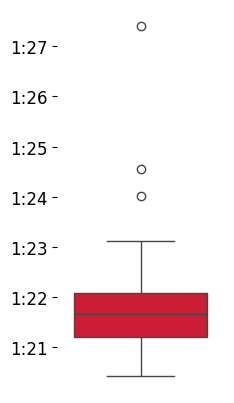

In [141]:
show_pace_comp(team, session)

In [ ]:
def show_laptime_scatterplot(team, team_drivers, session):
    driver_1_laps, driver_2_laps = fixed_nat_fast_laps(team, session)
    driver_1_laps = pd.DataFrame(driver_1_laps)
    driver_2_laps = pd.DataFrame(driver_2_laps)
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)

    if driver_1_laps.empty and driver_2_laps.empty:
        print("No valid lap times to display.")
        return
    elif driver_1_laps.empty:
        min_laptime = min(driver_2_laps['LapTime'])
        max_laptime = max(driver_2_laps['LapTime'])
    elif driver_2_laps.empty:
        min_laptime = min(driver_1_laps['LapTime'])
        max_laptime = max(driver_1_laps['LapTime'])
    else:
        min_laptime = min(min(driver_1_laps['LapTime']), min(driver_2_laps['LapTime']))
        max_laptime = max(max(driver_1_laps['LapTime']), max(driver_2_laps['LapTime']))

    min_laptime = min_laptime - timedelta(seconds= 1)
    max_laptime = max_laptime + timedelta(seconds= 1)

    last_lap = int(max(session.laps['LapNumber'])) + 1
    
    fig, ax = plt.subplots(figsize=(5.75, 4.2), facecolor='none')
    ax.set_facecolor('none')
    
    palette = fastf1.plotting.get_compound_mapping(session=session)
    palette['nan'] = palette['UNKNOWN']
    palette['nan'] = '#00ffff'
    
    if driver_1_laps.empty:
        driver_1_laps.loc[0] = 0.0
        driver_1_laps['DriverNumber'] = team_drivers[0]
        driver_1_laps['LapNumber'] = 0.0
        driver_1_laps['LapTime'] = pd.Timestamp('NaT').to_pydatetime()
        driver_1_laps['Compound'] = 'UNKNOWN'
    
    if driver_2_laps.empty:
        driver_2_laps.loc[0] = 0
        driver_2_laps['DriverNumber'] = team_drivers[1]
        driver_2_laps['LapNumber'] = 0.0
        driver_2_laps['LapTime'] = pd.Timestamp('NaT').to_pydatetime()
        driver_2_laps['Compound'] = 'UNKNOWN'
    

    if not driver_1_laps.empty:
        sns.scatterplot(data=driver_1_laps,
                        x="LapNumber",
                        y="LapTime",
                        hue = 'Compound',
                        palette=palette,
                        marker='s',
                        edgecolor = 'black',
                        s=50,
                        linewidth=1)

    if not driver_2_laps.empty:
        sns.scatterplot(data=driver_2_laps,
                        x="LapNumber",
                        y="LapTime",
                        hue = 'Compound',
                        palette=palette,
                        marker='D',
                        edgecolor = 'black',
                        s=50,
                        linewidth=1)
    
    ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
    ax.yaxis.set_major_formatter(FuncFormatter(microseconds_to_mmss))
    ax.invert_yaxis()
    ax.set_xlim([0, last_lap])
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(colors='white')

    plt.legend(frameon=False)
    plt.grid(color='w', which='major', axis='both', linestyle='dotted')
    plt.tight_layout()


In [110]:
def show_laptime_comp(team, session):
    driver_1_laps, driver_2_laps = fixed_nat_all_laps(team, session)
    last_lap = int(max(session.laps['LapNumber']))

    fig, ax = plt.subplots(figsize=(10, 5))
    if not driver_1_laps.empty:
        ax.plot(driver_1_laps['LapNumber'], driver_1_laps['LapTime'], color=fastf1.plotting.get_driver_color(team_drivers[0], session=session))
    if not driver_2_laps.empty: 
        ax.plot(driver_2_laps['LapNumber'], driver_2_laps['LapTime'], color=fastf1.plotting.get_driver_color(team_drivers[1], session=session))
    
    ax.tick_params(labelright=True)
    ax.set_xlim([0, last_lap])
    ax.yaxis.set_major_formatter(FuncFormatter(microseconds_to_mmss))

    plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
    
    plt.grid(color='w', which='major', axis='both', linestyle='dotted')   

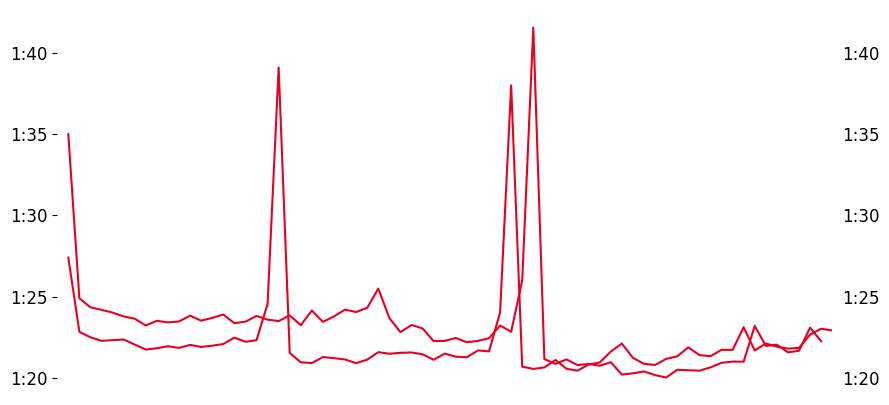

In [111]:
show_laptime_comp(team, session)

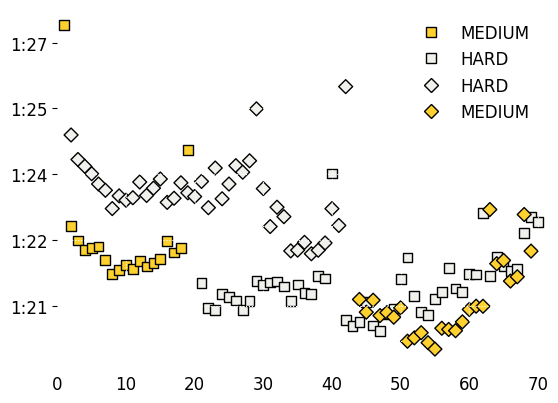

In [112]:
show_laptime_scatterplot(team, team_drivers, session)

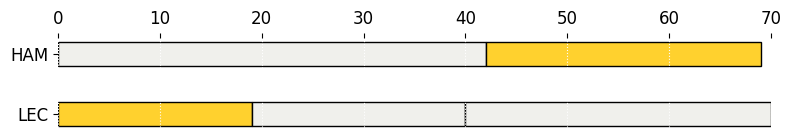

In [171]:
show_tyre_strategy(team, team_drivers,session)